Import libraries

In [ ]:
import tensorflow as tf
import keras, os, random, zipfile, csv
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, Input

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image
from PIL import Image
import torch
from keras.optimizers import SGD
!pip install keras-tuner
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.5 MB/s eta 0:00:00


Set Control Params

In [ ]:
train_the_model = 1
hp_tunning = 1
load_images_ndarray = 1;

Copy the files from the Drive

In [ ]:
from google.colab import drive
import shutil

drive.mount('/content/drive')
shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/Weights.csv', 'Weights.csv')
shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/Test_Ids.csv', 'Test_Ids.csv')
shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/arial.ttf', 'arial.ttf')
if train_the_model == 0:
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/Train_History_Dict', 'Train_History_Dict')
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/Trained_Reconstruction_Model.keras', 'Trained_Reconstruction_Model.keras')
if train_the_model == 1 & hp_tunning == 0:
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/NonTrained_Reconstruction_Model.keras', 'NonTrained_Reconstruction_Model.keras')
if load_images_ndarray == 1:
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/train_images.npy', 'train_images.npy')
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/test_images.npy', 'test_images.npy')
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/train_labels.npy', 'train_labels.npy')
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/test_labels.npy', 'test_labels.npy')
else:
    shutil.copy('/content/drive/MyDrive/2 - Reconstruction Network Data/AP_LT.zip', 'AP_LT.zip')
drive.flush_and_unmount()


Mounted at /content/drive


Reading labels and Test IDs from the files downloaded from the google drive

In [ ]:
def read_lines(filepath):
    with open(filepath, 'rU') as data:
        reader = csv.reader(data)
        for row in reader:
            yield [ float(i) for i in row ]

Labels_filepath = 'Weights.csv'
Labels = list(read_lines(Labels_filepath))

Test_Ids_filepath = 'Test_Ids.csv'
Test_Ids = list(read_lines(Test_Ids_filepath))
Test_Ids_Temp = []
for line in Test_Ids:
    Test_Ids_Temp.extend(map(int, line))
Test_Ids = Test_Ids_Temp

<ipython-input-4-3df98f13c55c>:2: DeprecationWarning: 'U' mode is deprecated
  with open(filepath, 'rU') as data:


Read the .png images if .npy file is not available

In [ ]:
if load_images_ndarray == 0:
    image_zip_address = '/content/AP_LT.zip'
    images_dir = '/content/AP_LT/'

    with zipfile.ZipFile(image_zip_address, 'r') as zip_ref:
        zip_ref.extractall('/content')

Check the labels

In [ ]:
print(len(Test_Ids))
print(len(Labels))
print(len(Labels[0]))
print(Labels[0])
print(Labels[99])

3000
30000
22
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[-53.0016562455176, -30.3131156446782, 47.3368141254733, -67.2208429607154, 29.5636296995274, -52.4570058526085, -4.66390613952465, -52.6705109748065, 14.364206431397, 17.8423095307194, -17.1646559931991, 7.26353536949193, 3.46826093163362, 23.1762961044226, 2.35820155788212, 18.4643948449593, -1.96092188898584, -10.2321125554126, -0.00192204080546617, -0.0425926413902944, 0.299616671691781, -0.011302683168452]


Set the proper settings regarding the Dataset

In [ ]:
image_resolutions = [480, 280] # used 2*MV, files are indicated as old everywhere. Ran on March 17
image_resolutions = [490, 290] # Used 3*MV
image_resolutions = [890, 460] # Used 3*MV original size
image_resolutions = [623, 322] # Used 3*MV, cause the images are large for GPU memory
train_test_percentage = 0.1

**Split the Train and Test data randomly (With BG)**

In [ ]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

if load_images_ndarray == 0:

    files = sorted_alphanumeric(os.listdir(images_dir))
    # files.sort()
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []

    for idx, file in enumerate(files):
        if len(train_images) < 5000:
            my_image = tf.io.read_file(images_dir + file)
            # print(file)
            tensor = tf.io.decode_image(my_image, channels=1, dtype=tf.dtypes.uint8)
            tensor_image = tf.image.resize(tensor, [image_resolutions[0], image_resolutions[1]])
            tensor_image = tf.cast(tensor_image, dtype=tf.uint8)
            # tensor_image = tf.image.rgb_to_grayscale(tensor_image)
            # if len(tensor_image.shape) == 3:
            #    tensor_image = tf.expand_dims(tensor_image, axis=0)
            if (len(tensor_image.shape) > 3):
                print(tensor_image.shape)
                tensor_image = tf.squeeze(tensor_image, axis=0)
                print(tensor_image.shape)
            if Test_Ids.count(idx) > 0:
                test_images.append(tensor_image)
                test_labels.append(Labels[idx][:])
                # test_labels.append(Labels[idx][22:]) # Similarity Transformation only
                # test_labels.append(Labels[idx][0:1])
            else:
                if train_the_model == 1:
                    train_images.append(tensor_image)
                    train_labels.append(Labels[idx][:])
                else:
                  if idx < 20: # We don't need the training images. In this way we will save memory
                    train_images.append(tensor_image)
                    train_labels.append(Labels[idx][:])
                # train_labels.append(Labels[idx][22:])
                # train_labels.append(Labels[idx][0:1])

    train_images = tf.stack(train_images)
    test_images = tf.stack(test_images)

    np.save('train_images.npy', train_images)
    np.save('test_images.npy', test_images)
    np.save('train_labels.npy', train_labels)
    np.save('test_labels.npy', test_labels)
    drive.mount('/content/drive')
    shutil.copy("train_images.npy", "/content/drive/MyDrive/2 - Reconstruction Network Data/train_images.npy")
    shutil.copy("test_images.npy", "/content/drive/MyDrive/2 - Reconstruction Network Data/test_images.npy")
    shutil.copy("train_labels.npy", "/content/drive/MyDrive/2 - Reconstruction Network Data/train_labels.npy")
    shutil.copy("test_labels.npy", "/content/drive/MyDrive/2 - Reconstruction Network Data/test_labels.npy")
    drive.flush_and_unmount()
else:
    train_images = np.load("train_images.npy")
    test_images = np.load("test_images.npy")
    train_labels = np.load("train_labels.npy")
    test_labels = np.load("test_labels.npy")

Normalization of the output (Labels)

In [ ]:
labels_num = len(Labels)
feature_size = len(Labels[0])
feature_max_values = np.zeros((feature_size))
for i in range(feature_size):
  max_feature = 0;
  for j in range(labels_num):
    if max_feature < np.abs(Labels[j][i]): # max_feature < np.abs(Labels[j][i+22]):
      max_feature = np.abs(Labels[j][i]) # max_feature = np.abs(Labels[j][i+22]):
  feature_max_values[i] = max_feature

for i in range(feature_size):
  for j in range(len(train_labels)):
    train_labels[j][i] = train_labels[j][i]/feature_max_values[i]
  for j in range(len(test_labels)):
    test_labels[j][i] = test_labels[j][i]/feature_max_values[i]

train_labels = tf.stack(train_labels)
test_labels = tf.stack(test_labels)

Check the size of train and test sets

In [ ]:
print(len(train_images))
print(len(test_images))
print(len(train_labels))
print(len(test_labels))

5000
540
5000
540


Plot some images randomly

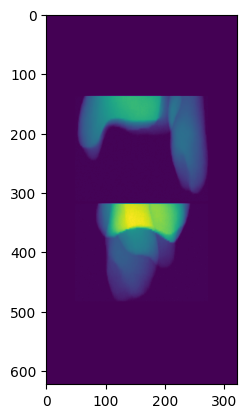

In [ ]:
%matplotlib inline

rand_idx = random.randint(0, len(test_images))
rand_idx = 0
im = test_images[rand_idx]
plt.imshow(im)

Check images dataset sizes

In [ ]:
print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)

(5000, 623, 322, 1)
(540, 623, 322, 1)
(5000, 22)
(540, 22)


Create the model

Best run on Dec. 11
learning_rate = 0.1
batch_size = 10
dropout_rate = 0.2

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def create_model(image_resolutions, output_size, learning_rate, dropout_rate=0.2):

    # Input layer
    inputs = Input(shape=(image_resolutions[0], image_resolutions[1], 1))

    # Convolutional layers
    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(inputs)
    x = Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Flatten and Dense layers
    x = Flatten()(x)
    x = Dense(units=4096, activation="relu")(x)
    x = Dropout(dropout_rate)(x)  # Dropout layer
    x = Dense(units=4096, activation="relu")(x)
    x = Dropout(dropout_rate)(x)  # Dropout layer
    outputs = Dense(units=output_size)(x)  # Output layer

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), loss='mean_absolute_error')
    #model.summary()
    return model  # Return the model

def scheduler(epoch, lr):
  match epoch:
    case 15:
         return lr*0.5
    case 30:
         return lr*0.5
    case 50:
         return lr*0.5
    case 70:
         return lr*0.5
    case _:
        return lr

# Loss functions
def weighted_MAE(y_true, y_pred):
    A = tf.math.subtract(y_true, y_pred);
    tf.print(A)
    print(type(y_true))
    print(type(y_pred))
    #print(MAE_weights)
    B = tf.math.multiply(MAE_weights, A)
    tf.math.reduce_mean(B)
    tf.print(B)
    return B

Create a dummy network to plot the architecture

In [ ]:
import pickle
if train_the_model == 0:
    #model = tf.keras.models.load_model('Trained_Reconstruction_Model.keras')
    with open('Train_History_Dict', "rb") as file_pi:
        history = pickle.load(file_pi)

Hyperparemters tuning: Dropout rate, Learning rate, batchsize

[['0.01', '0.2', '8', '0.2124193161725998'], ['0.01', '0.2', '12', '0.23283711075782776'], ['0.01', '0.2', '16', '0.2199714332818985'], ['0.01', '0.3', '8', '0.22135353088378906'], ['0.01', '0.3', '12', '0.22852256894111633'], ['0.01', '0.3', '16', '0.22736026346683502'], ['0.01', '0.4', '8', '0.22627988457679749'], ['0.01', '0.4', '12', '0.2351701855659485'], ['0.01', '0.4', '16', '0.2394513636827469'], ['0.05', '0.2', '8', '0.1904037743806839'], ['0.05', '0.2', '12', '0.22566944360733032'], ['0.05', '0.2', '16', '0.20781682431697845'], ['0.05', '0.3', '8', '0.20030809938907623'], ['0.05', '0.3', '12', '0.22664377093315125'], ['0.05', '0.3', '16', '0.21267259120941162'], ['0.05', '0.4', '8', '0.21701015532016754'], ['0.05', '0.4', '12', '0.22369182109832764'], ['0.05', '0.4', '16', '0.22194808721542358'], ['0.1', '0.2', '8', '0.2044145166873932'], ['0.1', '0.2', '12', '0.22423094511032104'], ['0.1', '0.2', '16', '0.2042679488658905'], ['0.1', '0.3', '8', '0.19711410999298096'], ['0.1'

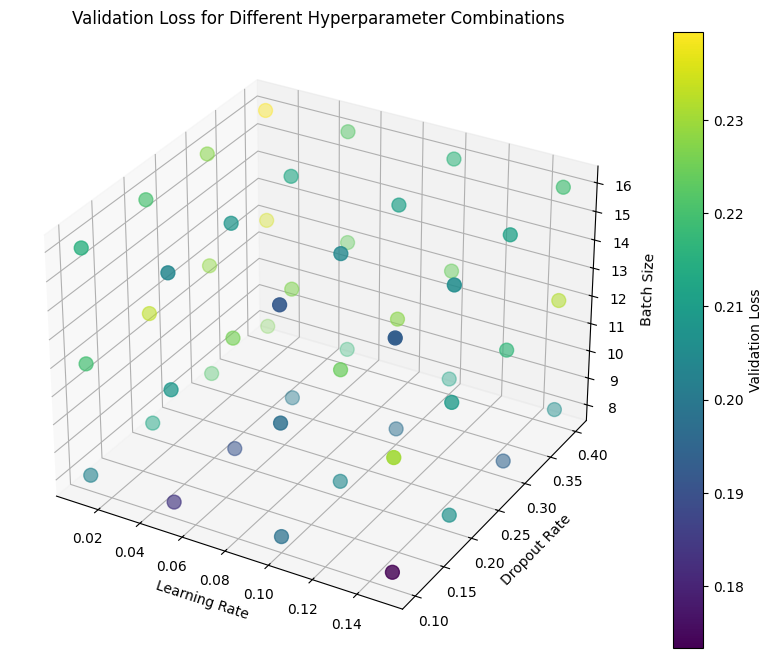

"\nplt.plot(history.history['val_loss'], label='Validation Loss')\nplt.xlabel('Epochs')\nplt.ylabel('Validation Loss')\nplt.title('Validation Loss over Epochs for the Best Model')\nplt.legend()\nplt.show()"

In [ ]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV

network_output_size = 22
hp_tunning = 0
if hp_tunning == 1:
    # Hyperparameter grid search space
    learning_rates = [0.01, 0.05, 0.1, 0.15]
    dropout_rates = [0.1]
    batch_sizes = [8, 12, 16]

    # Store the results for each combination
    results = []
    counter = 0;
    # Grid search manually
    for lr in learning_rates:
        for dr in dropout_rates:
            for bs in batch_sizes:
                if counter >= 0:
                    print(f"{counter} Training with Learning Rate: {lr}, Dropout Rate: {dr}, Batch Size: {bs}")

                    # Create the model for the current combination of hyperparameters
                    temp_model = create_model(image_resolutions, network_output_size, learning_rate=lr, dropout_rate=dr)

                    # Train the model
                    history = temp_model.fit(
                        train_images,
                        train_labels,
                        epochs=5,  # Reduced number of epochs for grid search
                        batch_size=bs,
                        validation_split=0.2,
                        verbose=1
                    )

                    # Record the validation loss for this combination
                    val_loss = history.history['val_loss'][-1]
                    results.append((lr, dr, bs, val_loss))

                    # Delete the model to save memory
                    del temp_model
                    tf.keras.backend.clear_session()
                counter = counter + 1
else:
    import csv

    # Specify the path to your CSV file
    filename = 'Reconstruction_Netowrk_HP_Optimization.csv'

    # Initialize an empty list to hold the data
    results = []

    # Open the CSV file and read its contents
    with open(filename, newline='') as file:
        reader = csv.reader(file)

        # Read each row from the CSV and append it as a list to list_of_lists
        for row in reader:
            results.append(row)

    # Now list_of_lists contains the data from the CSV file
    print(results)

# Sort the results by validation loss
results = sorted(results, key=lambda x: x[3])

# Best combination (lowest validation loss)
best_lr, best_dr, best_bs, best_val_loss = results[0]
print(f"Best Hyperparameters: Learning Rate: {best_lr}, Dropout Rate: {best_dr}, Batch Size: {best_bs}, Validation Loss: {best_val_loss}")

# Visualize the grid search results - Plot validation loss for each combination
# Visualize the grid search results - Plot validation loss for each combination
lr_vals = [float(x[0]) for x in results]  # Convert to float
dr_vals = [float(x[1]) for x in results]  # Convert to float
bs_vals = [int(x[2]) for x in results]    # Convert batch size to int
val_losses = [float(x[3]) for x in results]  # Convert validation loss to float

# Create a grid of plots (3D scatter plot)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D visualization
scatter = ax.scatter(lr_vals, dr_vals, bs_vals, c=val_losses, cmap='viridis', s=100)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Dropout Rate')
ax.set_zlabel('Batch Size')
ax.set_title('Validation Loss for Different Hyperparameter Combinations')

# Add color bar
fig.colorbar(scatter, label='Validation Loss')

plt.show()

# Visualize the learning curve for the best model
"""
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs for the Best Model')
plt.legend()
plt.show()"""

In [ ]:
with open("list_of_lists.csv", "w", newline='') as file:
    writer = csv.writer(file)
    writer.writerows(results)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

# Convert results to a DataFrame for easy plotting
results_df = pd.DataFrame(results, columns=['Learning Rate', 'Dropout Rate', 'Batch Size', 'Validation Loss'])

# Visualize the grid search results - Heatmap of validation loss for each combination of hyperparameters
pivot_df = results_df.pivot_table(index='Dropout Rate', columns='Learning Rate', values='Validation Loss')

plt.figure(figsize=(10, 7))
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.4f', linewidths=.5)
plt.title('Validation Loss for Different Hyperparameter Combinations')
plt.xlabel('Learning Rate')
plt.ylabel('Dropout Rate')
plt.show()

# 3D Scatter Plot of Hyperparameter combinations vs. Validation Loss
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D visualization
scatter = ax.scatter(results_df['Learning Rate'], results_df['Dropout Rate'], results_df['Batch Size'],
                     c=results_df['Validation Loss'], cmap='viridis', s=100)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Dropout Rate')
ax.set_zlabel('Batch Size')
ax.set_title('Validation Loss for Different Hyperparameter Combinations')

# Add color bar
fig.colorbar(scatter, label='Validation Loss')

plt.show()

# Optionally, visualize the learning curves (validation loss) for all combinations
plt.figure(figsize=(10, 6))
for lr, dr, bs, val_loss in results:
    # Create the model again for each combination and plot its learning curve
    temp_model = create_model(image_resolutions, network_output_size, learning_rate=lr, dropout_rate=dr)

    history = temp_model.fit(
        train_images_hp_tuning,
        train_labels_hp_tuning,
        epochs=10,  # Reduced number of epochs for grid search
        batch_size=bs,
        validation_split=0.2,
        verbose=0
    )

    plt.plot(history.history['val_loss'], label=f"LR={lr}, DR={dr}, BS={bs}")

plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss over Epochs for Different Hyperparameter Combinations')
plt.legend()
plt.show()

In [ ]:
"""from google.colab import runtime
runtime.unassign()"""